# <b>2 - Reviewing Process Mining with a Simulated Random Process</b>

Purpose:   
Review techniques for Process Mining using a simulated random process in order to gain familiarity and explore application of techniques. 

Resources:   
- https://pm4py.fit.fraunhofer.de/documentation   
- https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5   

Summary:   
- The application of Process Mining techniques is straightforward with the pm4py package
- Challenge and value is in effective and efficient conversion of datasets to align to required format for package

   
-----

<b>Initial Imports</b>   
Imports for specific techniques handled later

In [1]:
import random
from datetime import datetime, timedelta
import pandas as pd
import boto3
from io import StringIO
import pm4py

-----

## <b>Simulation</b>

Summary of the random process:   
There are six forms of the process flow. All begin with 'start' and all terminate with 'end'. There's an 80% chance that the process will follow the first two flows. There's a 14% chance of an approval required on a normal flow. There's a 5% chance of a special approval flow. There's a 1% chance of a process bypass. A random number is used to simulate which flow is followed.   
10,000 simulations were completed.

In [2]:
process_scenarios = {
                    "a": ['start','a','b','c','end'], # 40 percent
                    "b": ['start','a','d','e','end'], # 40 percent
                    "c": ['start','a','b','c','a_approval','end'], # 7 percent
                    "d": ['start','a','d','e','b_approval','end'], # 7 percent 
                    "e": ['start','a','f','f_approval','end'], # 5 percent
                    "f": ['start','bypass','end'] # 1 percent
                    }

In [3]:
def get_action_date(f_days):
    process_start_date = datetime(2001,1,1)
    return process_start_date + timedelta(f_days)
    

In [4]:
def get_scenario(f_rand_val, f_scenarios):
    tmp_val = ''
    tmp_val = f_scenarios['a'] if (f_rand_val <= 40) else tmp_val
    tmp_val = f_scenarios['b'] if (f_rand_val > 40 and f_rand_val <= 80) else tmp_val
    tmp_val = f_scenarios['c'] if (f_rand_val > 80 and f_rand_val <= 87) else tmp_val
    tmp_val = f_scenarios['d'] if (f_rand_val > 87 and f_rand_val <= 94) else tmp_val
    tmp_val = f_scenarios['e'] if (f_rand_val > 94 and f_rand_val <= 99) else tmp_val
    tmp_val = f_scenarios['f'] if (f_rand_val > 99) else tmp_val
    return tmp_val

In [5]:
def simulate_event(flow_id, date_id):
    rand_event = int( round( random.random() * 100 , 2))
    tmp_date_id = date_id
    flow_scenario = get_scenario( rand_event, process_scenarios )
    tmp_flow = []
    for flow in flow_scenario: 
        event_date = get_action_date(tmp_date_id)
        tmp_date_id += 1
        tmp_flow.append([flow_id, event_date.strftime('%m/%d/%Y'), flow])
    return tmp_flow, tmp_date_id

In [6]:
date_id = 1
flow_id = 1
simulation_list = []
while flow_id < 10001:
    sim_flow, date_id = simulate_event(flow_id, date_id)
    for event in sim_flow:
        simulation_list.append(event)
    flow_id += 1

In [7]:
simulation_df = pd.DataFrame(simulation_list)

In [8]:
simulation_df.columns = ['flow_id','event_date','event']

In [9]:
simulation_df.head(10)

,flow_id,event_date,event
0,1,01/02/2001,start
1,1,01/03/2001,a
2,1,01/04/2001,b
3,1,01/05/2001,c
4,1,01/06/2001,end
5,2,01/07/2001,start
6,2,01/08/2001,a
7,2,01/09/2001,b
8,2,01/10/2001,c
9,2,01/11/2001,end


----- 

## <b>Process Mining</b>

### <b>Process Mining Log Conversion</b>

In [10]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

In [11]:
sim_event_df = dataframe_utils.convert_timestamp_columns_in_df(simulation_df)

In [12]:
sim_event_df = sim_event_df.sort_values('event_date')

In [13]:
sim_event_df.columns = ['case:concept:name','time:timestamp','concept:name']

In [14]:
log_util_params = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}

In [15]:
sim_event_log = log_converter.apply(sim_event_df, parameters=log_util_params, variant=log_converter.Variants.TO_EVENT_LOG)

### <b>Alpha Miner</b>

In [16]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

In [17]:
net, initial_marking, final_marking = alpha_miner.apply(sim_event_log)

In [18]:
from pm4py.visualization.petrinet import visualizer as pn_visualizer

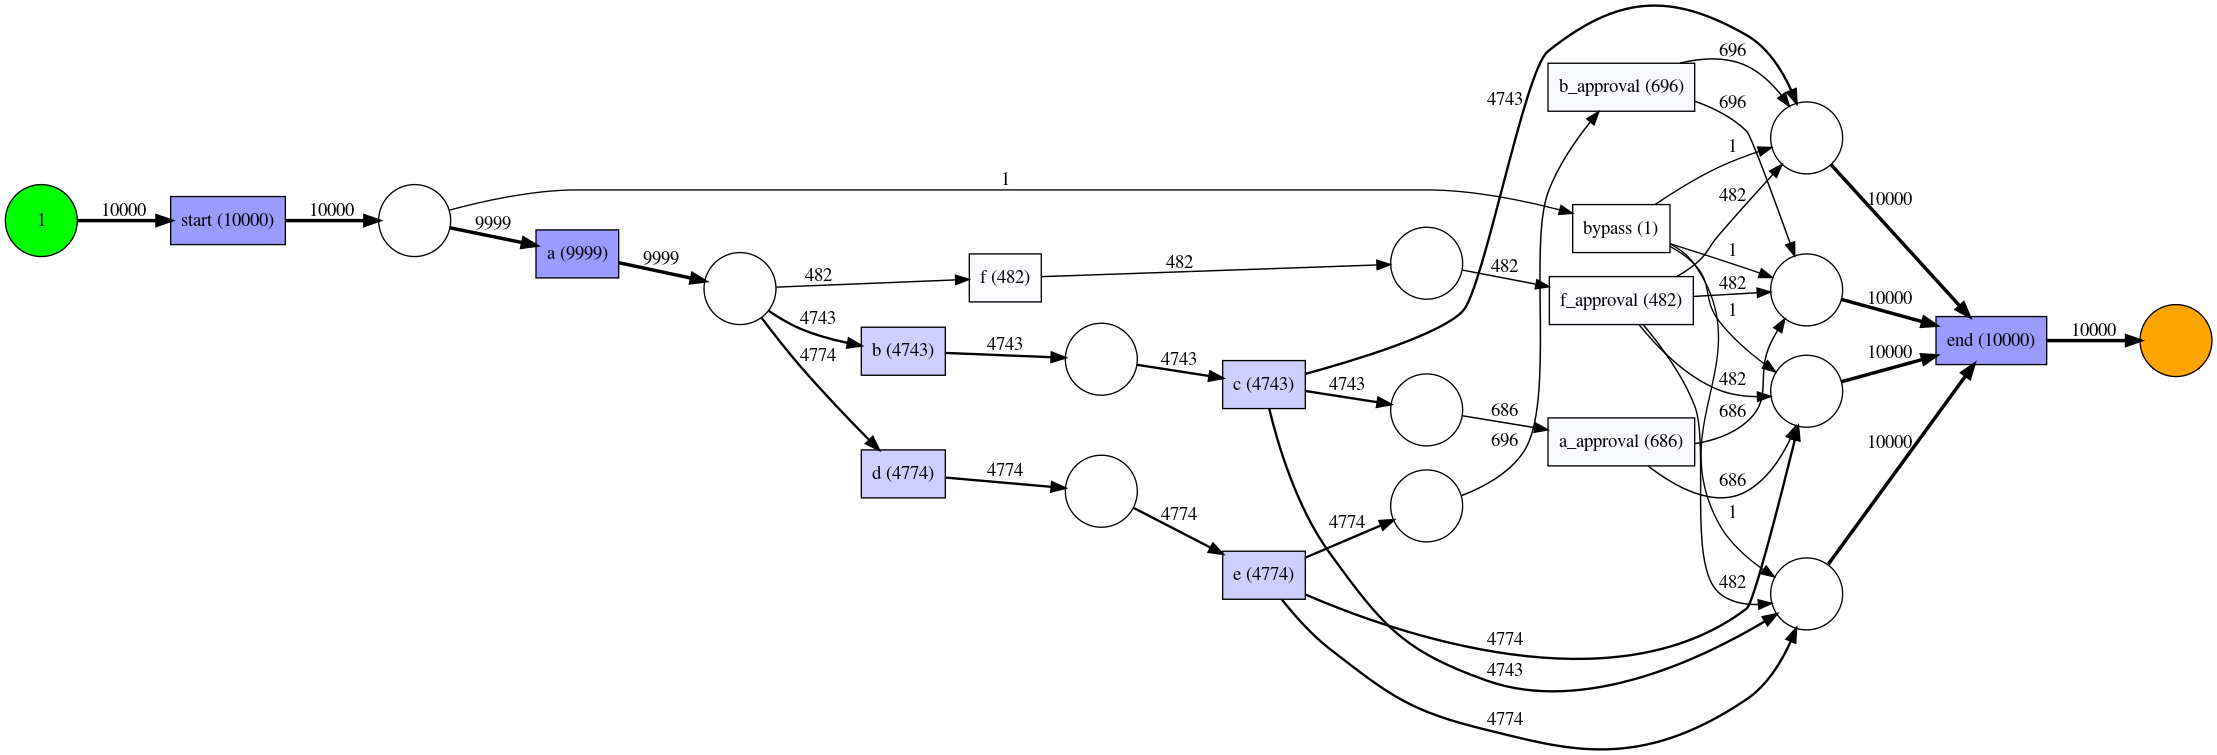

In [19]:
viz_params = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz_am = pn_visualizer.apply(net, initial_marking, final_marking,
                             parameters = viz_params,
                             variant=pn_visualizer.Variants.FREQUENCY,
                             log=sim_event_log)
pn_visualizer.view(gviz_am)

# some of the frequency notations are confusing, but they might be there in expectation of process drop out
# in the simulation, there are no process starts that do no results in a process end

### <b>Directly-Follows Graph

In [20]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

In [21]:
sim_dfg = dfg_discovery.apply(sim_event_log)

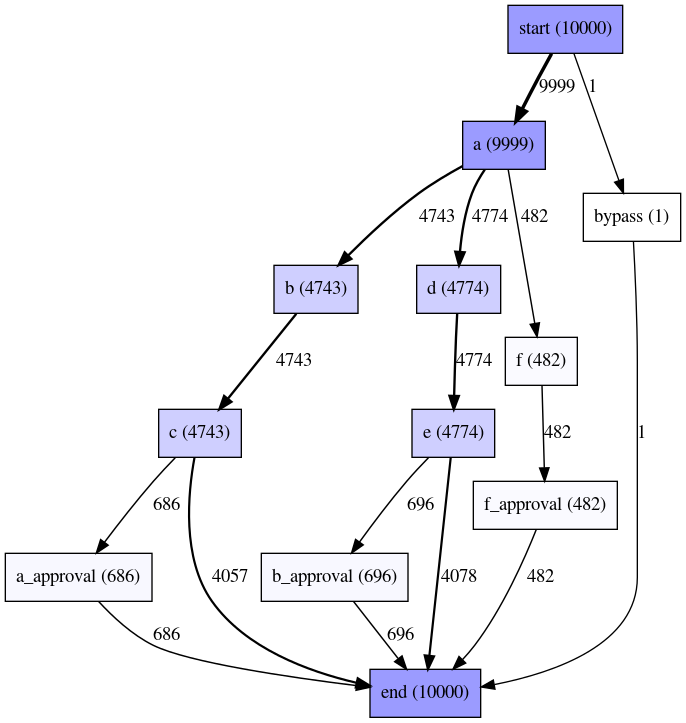

In [22]:
gviz_dfg = dfg_visualization.apply(sim_dfg, log=sim_event_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz_dfg)

### <b>Heuristic Miner</b>

In [23]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

In [24]:
sim_heu = heuristics_miner.apply_heu(sim_event_log)

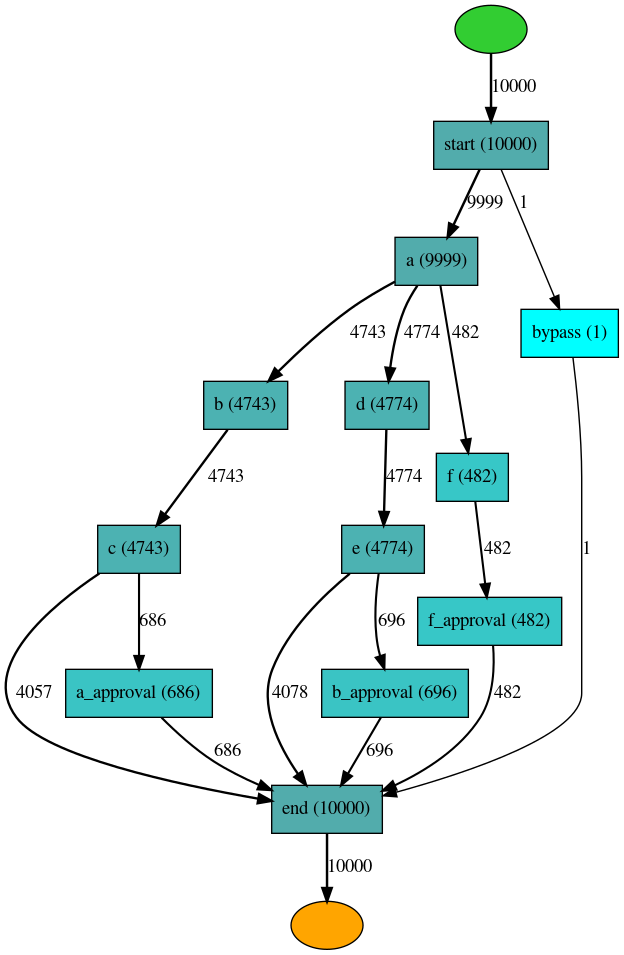

In [25]:
gviz_heu = hn_visualizer.apply(sim_heu)
hn_visualizer.view(gviz_heu)

### <b>Inductive Miner</b>

In [26]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer

In [27]:
sim_tree = inductive_miner.apply_tree(sim_event_log)

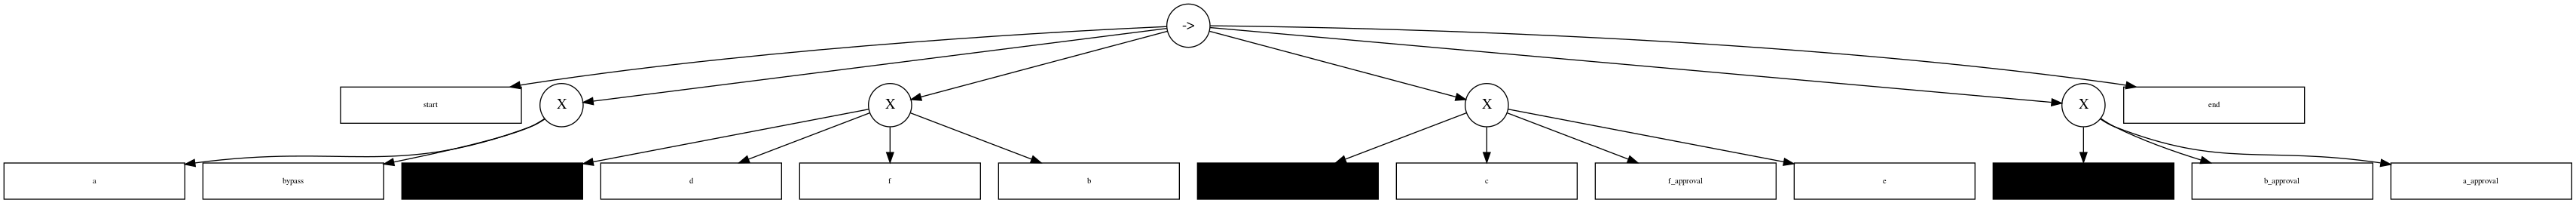

In [28]:
gviz_tree = pt_visualizer.apply(sim_tree)
pt_visualizer.view(gviz_tree)